Import necessary packages.

In [18]:
%matplotlib inline

import pandas as pd
import numpy as np
import math
import datetime as dt
import quandl
import matplotlib.pyplot as plt
import seaborn as sns

Define functions to download futures pricing data via Quandl API and then stitch futures prices together. 

Futures are contracts that expire at regular intervals (typically based on expiration months). For our strategy, we use only the most liquid and highly traded expiration months. We then stitch together prices for futures contracts of a given instrument in order to have sufficient historical price data. The method employed here is known as the 'Panama Method'. 

In [10]:
def get_futures_info():
    """Retrieves futures contract data from Github."""
    df = pd.read_csv('https://raw.githubusercontent.com/haobruce/SysTrade/master/SysTrade_FuturesContracts.csv')
    return df


def get_strategy_info():
    """Retrieves strategy information from Github."""
    df = pd.read_csv('https://raw.githubusercontent.com/haobruce/SysTrade/master/SysTrade_Strategies.csv')
    df['AdjWeight'] = df['UnadjustedWeight'] * df['CostAdjustment']
    df = df[['Rule', 'Variation', 'UnadjustedWeight', 'CostAdjustment', 'AdjWeight', 'ScalarPooled']]
    return df


def get_correlation_matrix(symbols_list):
    """Retrieves futures contract correlation matrix from Github."""
    df = pd.read_csv('https://raw.githubusercontent.com/haobruce/SysTrade/master/SysTrade_CorrelationMatrix.csv')
    df.set_index('Symbol', inplace=True)
    df = df.loc[symbols_list][symbols_list]
    return df


def construct_futures_symbols(symbol, start_year=2015, end_year=dt.date.today().year):
    """Constructs a list of futures contract codes for a
    particular symbol and time frame."""
    futures = []
    # append expiration month code to symbol name
    futures_info = get_futures_info()
    months = futures_info['ExpMonths'].loc[futures_info['Symbol'] == symbol].values[0]
    if futures_info.loc[futures_info['Symbol'] == symbol]['YearLimit'].values[0] > start_year:
        start_year = int(futures_info.loc[futures_info['Symbol'] == symbol]['YearLimit'].values[0])
    end_year += math.ceil(futures_info.loc[futures_info['Symbol'] == symbol]['TradedContract'].values[0] / len(months))

    for y in range(start_year, end_year + 1):
        for m in months:
            futures.append("%s%s%s" % (symbol, m, y))
    return futures


def download_historical_prices(symbol):
    """Downloads futures pricing data from Quandl for a specific contract."""
    auth_token = 'g1CWzGxxg2WxNVbV5n9y'

    # add exchange prefix to symbol name
    futures_info = get_futures_info()
    prefix = futures_info['Exchange'].loc[futures_info['Symbol'] == symbol[:-5]].values[0]  # strip off month and year
    full_name = prefix + '/' + symbol

    prices = pd.DataFrame()
    try:
        # download prices from quandl using full_name
        prices = quandl.get(full_name, authtoken=auth_token)
        prices = prices['Settle']
        # add contract_sort in order to sort by year then by month using contract name
        prices = pd.DataFrame({'Settle': pd.Series(prices),
                               'Contract': symbol,
                               'Contract_Sort': symbol[-4:] + symbol[-5:-4] + symbol[:-5]})
    except:
        pass
    return prices


def compile_historical_prices(symbol, start_year=2015, end_year=dt.date.today().year):
    """Combines futures pricing data for contracts within specified date range
    for a specific symbol."""
    symbol_list = construct_futures_symbols(symbol, start_year, end_year)
    prices = download_historical_prices(symbol_list[0])
    for sym in symbol_list[1:]:
        next_prices = download_historical_prices(sym)
        prices = next_prices.append(prices)
    return prices


def get_active_contracts(symbol, full_prices):
    """Constructs a data frame of active contracts, i.e. next-nearest contract, by date
    within specified date range."""
    # find unique dates since fullPrices repeats date index as contracts overlap
    unique_dates = full_prices.sort_index().index.unique()
    # create data frame with unique dates as index
    df = pd.DataFrame({'Date': unique_dates})
    df = df.set_index(['Date'])
    df.insert(0, 'Symbol', symbol)
    # determine which contract to trade, e.g. 2nd nearest or 12th nearest
    futures_info = get_futures_info()
    traded_contract = futures_info.loc[futures_info['Symbol'] == symbol]['TradedContract'].values[0]
    # find active contract for each date in data frame
    for d in df.index:
        # check that there are sufficient contracts available on a given date
        # sort by contract_sort but use contract name
        if len(full_prices.sort_index()[d:d].sort_values('Contract_Sort')['Contract'].index) >= traded_contract:
            df.loc[d, 'Contract'] = full_prices.sort_index()[d:d].sort_values('Contract_Sort')['Contract'][traded_contract - 1]
            df.loc[d, 'Contract_Sort'] = full_prices.sort_index()[d:d].sort_values('Contract_Sort')['Contract_Sort'][traded_contract - 1]
    # check that most recent contract has recent pricing data
    for contract in df['Contract_Sort'].sort_values(ascending=False).unique()[0:]:
        if max(df.loc[df['Contract_Sort'] == contract].index) < max(df.index):
            df = df.loc[df['Contract_Sort'] != contract]
        else:
            break
    # delete empty rows
    df = df[df['Contract'] == df['Contract']]
    return df


def get_active_prices(symbol, full_prices):
    """Stitches together futures prices based on Panama Method."""
    df = get_active_contracts(symbol, full_prices)
    # add settle prices to most recent contract
    contract = df['Contract_Sort'].sort_values(ascending=False).unique()[0]
    # check that most recent contract has recent pricing data

    prices = full_prices[full_prices['Contract_Sort'] == contract]
    # add column for unadjusted settle prices for easier checking
    df.loc[df['Contract_Sort'] == contract, 'SettleRaw'] = prices['Settle']
    df.loc[df['Contract_Sort'] == contract, 'Settle'] = prices['Settle']
    # stitch settle prices to remainder of contracts
    for contract in df['Contract_Sort'].sort_values(ascending=False).unique()[1:]:
        prices = full_prices[full_prices['Contract_Sort'] == contract]
        df_prices = df[df['Settle'] == df['Settle']]  # exclude rows with missing prices
        df_prices = df_prices.loc[df_prices.index.isin(prices.index)]  # include only dates in both df and prices
        end_date = df_prices.index.min().to_pydatetime()  # identify earliest date
        adjustment = df['Settle'][end_date] - prices['Settle'][end_date]
        df.loc[df['Contract_Sort'] == contract, 'SettleRaw'] = prices['Settle']
        df.loc[df['Contract_Sort'] == contract, 'Settle'] = prices['Settle'] + adjustment
    return df


Define functions to calculate trading rule forecasts based on stitched pricing. 

We are using two trading rules: 1) trend following and 2) carry. Trends are measured using two exponentially weighted moving averages - one faster and one slower. When the faster EWMA is above the slower EWMA, it suggests the trend is positive. The reverse is also true. Carry is the return earned when nothing else changes, i.e. interest in a loan. In the context of futures, e.g. gold contracts, we compare the price of futures contracts expiring in different months. Using the spot price and +1 month futures contract as an example, if the spot price of gold is $1200 and the +1 month futures contract price is $1150, we would earn $50 on the futures contract if the spot stayed at $1200 for the month. 

In [11]:
def get_forecast_inputs(symbol, start_year=2015, end_year=dt.date.today().year):
    """Constructs data frame with necessary data for all strategy forecast
     calculations, e.g. EWMAC, carry, etc."""
    futures_info = get_futures_info()
    price_source = futures_info.loc[futures_info['Symbol'] == symbol]['PriceSource'].values[0]
    if price_source != 'csv':
        full_prices = compile_historical_prices(symbol, start_year, end_year)
        # get data for active contract
        df = get_active_prices(symbol, full_prices)
        # add month and year to data frame
        df['Month'] = df['Contract'].str[-5]
        df['Year'] = pd.to_numeric(df['Contract'].str[-4:])

        # add previous month
        futures_info = get_futures_info()
        months = futures_info['ExpMonths'].loc[futures_info['Symbol'] == symbol].values[0]
        for i, month in enumerate(months):
            if i == 0:  # first month
                df.loc[df['Month'] == month, 'PrevMonth'] = months[-1]
                df.loc[df['Month'] == month, 'Year'] = df['Year']-1
            else:
                df.loc[df['Month'] == month, 'PrevMonth'] = months[i-1]

        # add data for prev contract
        df['PrevContract'] = df['Symbol'] + df['PrevMonth'] + df['Year'].astype(str)
        # add raw settle prices for prev contract
        for contract in df['PrevContract'].unique()[::-1]:
            prices = full_prices[full_prices['Contract'] == contract]
            df.loc[df['PrevContract'] == contract, 'PrevSettleRaw'] = prices['Settle']
        # remove NaN rows as some contracts have longer histories than others
        df = df[pd.notnull(df['PrevSettleRaw'])]
    else:
        df = get_active_prices_csv(symbol)

    # add data for return volatility based on raw price data
    df['ReturnDay'] = df['Settle'] - df['Settle'].shift(1)
    df['ReturnDayPct'] = df['Settle'] / df['Settle'].shift(1) - 1.0
    df = df[1:]  # drop first day without return
    df['ReturnDaySq'] = df['ReturnDay'] ** 2
    df['Variance'] = pd.ewma(df['ReturnDaySq'], span=36)
    df['PriceVolatility'] = df['Variance'] ** 0.5
    df['PriceVolatilityPct'] = df['PriceVolatility'] / df['SettleRaw']
    return df


def calc_ewmac_crossovers(forecast_inputs, fast_days, slow_days):
    """Constructs data frame comprised of volatility adjusted crossovers for a specified
    forecasts_input data frame and speed parameters for the EWMAC strategies."""
    df = forecast_inputs.copy()
    df['Fast'] = pd.ewma(df['Settle'], span=fast_days)
    df['Slow'] = pd.ewma(df['Settle'], span=slow_days)
    df['RawCrossover'] = df['Fast'] - df['Slow']
    df['VolAdjCrossover'] = df['RawCrossover'] / df['PriceVolatility']
    df['ScalarUnpooled'] = 10 / np.nanmedian(np.abs(df['VolAdjCrossover']))
    return df


def calc_ewmac_scalars(fast_days, slow_days):
    """Calculates pooled scalar value for EWMAC strategies."""
    scalar_list = []
    symbols_list = get_futures_info()
    symbols_list = symbols_list.loc[symbols_list['Include'] == 'Y']['Symbol'].tolist()
    for symbol in symbols_list:
        forecast_inputs = get_forecast_inputs(symbol)
        ewmac_crossovers = calc_ewmac_crossovers(forecast_inputs, fast_days, slow_days)
        scalar_list.append(ewmac_crossovers['ScalarUnpooled'][0])
    # consider weighting instrument scalars by number of periods available for each scalar
    return np.median(scalar_list)


def calc_ewmac_forecasts(forecast_inputs, fast_days, slow_days):
    """Constructs data frame comprised of forecasts for a specified
    forecasts_input data frame and speed parameters for the EWMAC strategies."""
    df = calc_ewmac_crossovers(forecast_inputs, fast_days, slow_days)
    variation = str(fast_days) + "," + str(slow_days)
    strategies = get_strategy_info()
    scalar_pooled = strategies.loc[strategies['Variation'] == variation]['ScalarPooled'].values[0]
    # uncomment line below if scalar_pooled to recalculate
    # scalar_pooled = calc_ewmac_scalars(fast_days, slow_days)
    df['ScalarPooled'] = scalar_pooled
    df['Forecast'] = df['VolAdjCrossover'] * df['ScalarPooled']
    df['ForecastCapped'] = df['Forecast']
    df.loc[df['Forecast'] > 20, 'ForecastCapped'] = 20
    df.loc[df['Forecast'] < -20, 'ForecastCapped'] = -20
    return df

def calc_carry_est_profits(forecast_inputs):
    """Constructs data frame comprised of forecasts for a specified
    forecasts_input data for the carry strategy."""
    df = forecast_inputs.copy()
    df['PrevLessActive'] = df['PrevSettleRaw'] - df['SettleRaw']
    # since time between contracts can vary whereas ewma crossovers are all daily,
    # carry forecast is normalized by annualizing estimated profit and dividing by annualized volatility
    months = 'FGHJKMNQUVXZ'
    distance_array = 12.0 / (np.char.find(months, df['Contract'].str[-5]) -
                             np.char.find(months, df['PrevContract'].str[-5]))
    distance_array[distance_array < 0] += 12
    df['Distance'] = distance_array
    df['PrevLessActiveAnn'] = df['PrevLessActive'] * df['Distance']
    df['VolAdjCarry'] = df['PrevLessActiveAnn'] / (df['PriceVolatility'] * 16)
    df['ScalarUnpooled'] = 10.0 / np.nanmedian(np.abs(df['VolAdjCarry']))
    return df


def calc_carry_scalars():
    """Calculates pooled scalar value for carry strategies."""
    scalar_list = []
    symbols_list = get_futures_info()
    symbols_list = symbols_list.loc[symbols_list['Include'] == 'Y']['Symbol'].tolist()
    for symbol in symbols_list:
        forecast_inputs = get_forecast_inputs(symbol)
        carry_est_profits = calc_carry_est_profits(forecast_inputs)
        scalar_list.append(carry_est_profits['ScalarUnpooled'][0])
    # consider weighting instrument scalars by number of periods available for each scalar
    return np.median(scalar_list)


def calc_carry_forecasts(forecast_inputs):
    """Constructs data frame comprised of forecasts for a specified
    forecasts_input data frame and speed parameters for the carry strategies."""
    df = calc_carry_est_profits(forecast_inputs)
    strategies = get_strategy_info()
    scalar_pooled = strategies.loc[strategies['Rule'] == 'CARRY']['ScalarPooled'].values[0]
    # uncomment line below if scalar_pooled to recalculate
    # scalar_pooled = calc_carry_scalars()
    df['ScalarPooled'] = scalar_pooled
    df['Forecast'] = df['VolAdjCarry'] * df['ScalarPooled']
    df['ForecastCapped'] = df['Forecast']
    df.loc[df['Forecast'] > 20, 'ForecastCapped'] = 20
    df.loc[df['Forecast'] < -20, 'ForecastCapped'] = -20
    return df

def calc_instrument_forecasts(symbol, start_year=2015, end_year=dt.date.today().year, threshold=False):
    """Constructs data frame comprised of instrument forecasts based on available
    strategies and weights."""
    forecast_inputs = get_forecast_inputs(symbol, start_year, end_year)
    df = forecast_inputs.copy()
    # loop through strategies and add strategy forecasts as separate columns
    strategies = get_strategy_info()
    for i in list(range(0, len(strategies))):
        if strategies.loc[i, 'Rule'] == 'EWMAC':
            fast = int(strategies.loc[i, 'Variation'].split(',')[0])
            slow = int(strategies.loc[i, 'Variation'].split(',')[1])
            strategy_name = strategies.loc[i, 'Rule'] + strategies.loc[i, 'Variation']
            df[strategy_name + 'Forecast'] = calc_ewmac_forecasts(forecast_inputs, fast, slow)['ForecastCapped']
        elif strategies.loc[i, 'Rule'] == 'CARRY':
            strategy_name = strategies.loc[i, 'Rule']
            if symbol == '3KTB':  # no carry calc for 3KTB since only one contract trades at a time
                df[strategy_name + 'Forecast'] = 0.0
                # set carry forecast equal to mean of ewmac forecasts
                # df[strategy_name + 'Forecast'] = (df['EWMAC16,64Forecast'] + df['EWMAC32,128Forecast'] +
                #                                   df['EWMAC64,256Forecast']) / 3.0
            else:
                df[strategy_name + 'Forecast'] = calc_carry_forecasts(forecast_inputs)['ForecastCapped']

        if threshold:
            df[strategy_name] = (-np.sign(df[strategy_name + 'Forecast']) * 30.0 + 3.0 * df[strategy_name + 'Forecast'])
            df[strategy_name].loc[df[strategy_name] > 30] = 30
            df[strategy_name].loc[df[strategy_name] < -30] = -30
            df[strategy_name].loc[np.abs(df[strategy_name + 'Forecast']) <= 10] = 0
        else:
            df[strategy_name] = df[strategy_name + 'Forecast']

    # calculate instrument forecast as weighted average of strategy forecasts
    forecasts = df[['EWMAC2,8', 'EWMAC16,64', 'EWMAC32,128', 'CARRY']]
    weights = strategies['AdjWeight']
    df['InstrumentForecast'] = np.dot(forecasts, weights)

    # calculate instrument value vol
    futures_info = get_futures_info()
    df['BlockSize'] = futures_info.loc[futures_info['Symbol'] == symbol, 'BlockSize'].values[0]
    df['BlockValue'] = df['SettleRaw'] * df['BlockSize'] * 0.01
    df['InstrumentCurVol'] = df['BlockValue'] * df['PriceVolatilityPct'] * 100
    # incorporate historical fx rates
    fx_symbol = futures_info.loc[futures_info['Symbol'] == symbol, 'FX'].values[0]
    if fx_symbol != 'USD':
        fx_symbol = 'CUR/' + futures_info.loc[futures_info['Symbol'] == symbol, 'FX'].values[0]
        fx_rates = quandl.get(fx_symbol)
        fx_rates.columns = ['Rate']
        df = df.merge(fx_rates, how='left', left_index=True, right_index=True)
    else:
        df['Rate'] = 1.0
    df['InstrumentValueVol'] = df['InstrumentCurVol'] / df['Rate']
    return df[['Symbol', 'Contract', 'SettleRaw', 'ReturnDayPct', 'PriceVolatility', 'PriceVolatilityPct',
               'InstrumentForecast', 'BlockSize', 'BlockValue', 'InstrumentValueVol', 'Rate']]


Define function to incorporate risk management and positioning sizing framework.

Once trading rule forecasts are computed, we need to assemble a portfolio of futures for our instruments. Our forecasts are measured in Sharpe ratio units with volatility as the denominator. That allows us to control the expected risk of our portfolio by setting a volatility target. We then incorporate some historical correlation data to account for the diversification benefits of instruments in disparate asset classes - otherwise, we would not hit our volatility target. With these pieces of information, we are then able to translate individual instrument forecasts into positions that make up a unified portfolio. 

In [12]:
def calc_position_targets(symbols_list=['ED', 'FVS', 'MGC', 'YC', 'YK'], starting_capital=15000.0, volatility_target=0.25):
    """Calculates position targets for actual trading."""
    # get asset class information for instrument weight calculation
    futures_info = get_futures_info()
    futures_info = futures_info.loc[futures_info['Symbol'].isin(symbols_list)]
    futures_info = pd.DataFrame({'Symbol': symbols_list}).merge(futures_info, how='left', on='Symbol')
    asset_classes = futures_info.groupby('AssetClass')['Symbol'].count()
    asset_classes = pd.DataFrame({'AssetClass': asset_classes.index, 'AssetClassCount': asset_classes.values})
    futures_info = futures_info.merge(asset_classes, how='left', on='AssetClass')

    # set scalar variables
    instrument_weight = 1.0 / len(asset_classes) / futures_info['AssetClassCount']
    # calculate diversification multiplier
    correlations = get_correlation_matrix(symbols_list)
    weights = pd.DataFrame({'Symbol': symbols_list, 'InstrumentWeight': instrument_weight})
    instrument_diversifier_multiplier = 1.0 / \
        np.array(weights['InstrumentWeight']).transpose().dot(correlations.dot(np.array(weights['InstrumentWeight']))) \
        ** 0.5

    df = pd.DataFrame()
    for symbol in symbols_list:
        forecast = calc_instrument_forecasts(symbol)
        df = df.append(forecast.iloc[-1])

    df['PortfolioValue'] = starting_capital
    df['DailyCashTargetVol'] = df['PortfolioValue'] * volatility_target / (256 ** 0.5)
    df['VolatilityScalar'] = df['DailyCashTargetVol'] / df['InstrumentValueVol']
    df['SubsystemPosition'] = df['InstrumentForecast'] / 10.0 * df['VolatilityScalar']
    df = df.merge(weights, how='left', on='Symbol')  # instrument weight
    df['InstrumentDiversifierMultiplier'] = instrument_diversifier_multiplier
    df['SystemPosition'] = df['SubsystemPosition'] * df['InstrumentWeight'] * instrument_diversifier_multiplier
    return df

Run function to determine appropriate position sizes for $250,000 portfolio at 25% annualized volatility target. 

In [13]:
position_targets = calc_position_targets(['YC', 'MGC', 'QG', 'FESX', 'MP', 'ED', 'FVS', 'YK'], 250000.0, 0.25)
position_targets

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:40: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=0,ignore_na=False,span=36,adjust=True).mean()
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:50: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=0,ignore_na=False,span=2,adjust=True).mean()
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:51: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=0,ignore_na=False,span=8,adjust=True).mean()
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:50: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=0,ignore_na=False,span=16,adjust=True).mean()
/usr/local/lib/python3.5/site-pack

,BlockSize,BlockValue,Contract,InstrumentForecast,InstrumentValueVol,PriceVolatility,PriceVolatilityPct,Rate,ReturnDayPct,SettleRaw,Symbol,PortfolioValue,DailyCashTargetVol,VolatilityScalar,SubsystemPosition,InstrumentWeight,InstrumentDiversifierMultiplier,SystemPosition
0,10.0,37.975,YCU2017,-9.189804,44.832773,4.483277,0.011806,1.00000,0.016054,379.750,YC,250000.0,3906.25,87.129341,-80.070155,0.071429,2.602589,-14.884979
1,10.0,125.680,MGCQ2017,0.457518,87.978523,8.797852,0.007000,1.00000,0.000557,1256.800,MGC,250000.0,3906.25,44.400041,2.031381,0.142857,2.602589,0.755264
2,2500.0,83.875,QGN2017,-10.558163,159.419186,0.063768,0.019007,1.00000,0.022866,3.355,QG,250000.0,3906.25,24.503011,-25.870678,0.142857,2.602589,-9.618677
3,10.0,355.700,FESXU2017,5.513620,325.721439,29.106142,0.008183,0.89359,0.007078,3557.000,FESX,250000.0,3906.25,11.992609,6.612269,0.142857,2.602589,2.458431
4,0.5,263.100,MPU2017,11.896095,194.637147,389.274293,0.007398,1.00000,0.008626,52620.000,MP,250000.0,3906.25,20.069396,23.874743,0.142857,2.602589,8.876592
5,2500.0,2448.625,EDH2020,11.644337,115.416160,0.046166,0.000471,1.00000,-0.000306,97.945,ED,250000.0,3906.25,33.844914,39.410158,0.142857,2.602589,14.652635
6,100.0,16.950,FVSN2017,-14.053777,57.038327,0.509689,0.030070,0.89359,-0.025862,16.950,FVS,250000.0,3906.25,68.484653,-96.246802,0.142857,2.602589,-35.784410
7,10.0,95.425,YKQ2017,-6.361679,90.769515,9.076951,0.009512,1.00000,0.007922,954.250,YK,250000.0,3906.25,43.034823,-27.377372,0.071429,2.602589,-5.089432


Visualize instrument forecast strength and recommended position sizes. 

As you can see in the charts below, the system is short Corn, Natural Gas, Euro Stoxx Volatility and Soy Bean. It is long Euro Stoxx, Mexican Peso and Eurodollar and is essentially flat on Gold. 

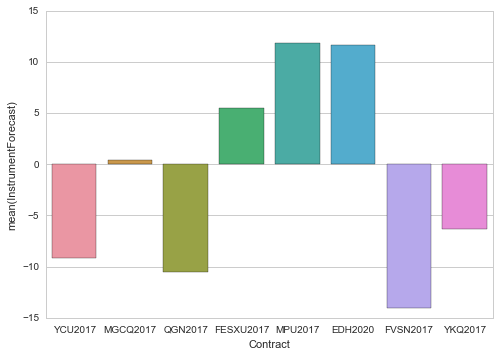

In [22]:
sns.set_style('whitegrid')
ax = sns.barplot(x = 'Contract', y = 'InstrumentForecast', data = position_targets)

The chart below reflects the actual position sizes in terms of number of contracts to be long or short. For example, although Mexican Peso and Eurodollar have the same forecast, the system requires more contracts of Eurodollar vs. Mexican Peso. This is a function of the contract units as well as recent volatility levels for each instrument - the more volatile, the fewer contracts are needed to meet the volatility requirement. 

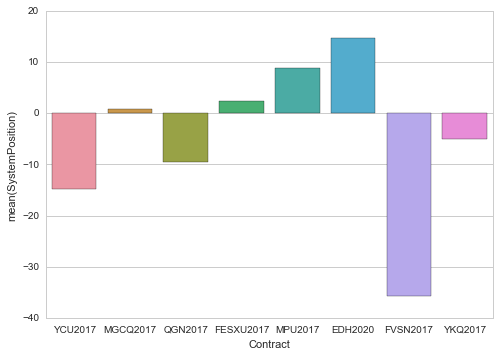

In [24]:
ax = sns.barplot(x = 'Contract', y = 'SystemPosition', data = position_targets)